In [5]:
import torch
import pandas as pd
import numpy as np
import tqdm
import torch.nn as nn
import argparse
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# from pykrx import stock
# df = stock.get_market_ohlcv("20220613","20230612","048410")
# df.to_csv('./data/현대바이오.csv')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, layers, output_size, normal_data):
        super(LSTMModel, self).__init__()
        torch.manual_seed(2023)
        self.normal_data = normal_data
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        ouputs, status = self.lstm(input)
        x = self.linear(ouputs[:, -1])
        return x
    
    def predict(self, predict_count):
        step = self.hidden_size
        predict_array = self.normal_data[-step:]
        for i in range(predict_count):
            train_data = torch.Tensor([predict_array[-step:]])
            prediction = self.forward(train_data)
            predict_array = np.append(predict_array, prediction.tolist(), axis=0)
        return predict_array[-predict_count:]

# many to one(x_count수를 input으로 1개를 예측)
def split_train(data, x_count):
    data = data.tolist()
    x_train = []
    for i in range(0, len(data)-x_count):
        x_train.append([[j] for j in data[i:i+x_count]])

    y_train = [[i] for i in data[x_count:]]

    return torch.Tensor(x_train), torch.Tensor(y_train)

(249, 1)
torch.Size([220, 4, 1])
torch.Size([220, 1])
[tensor(0.0030, grad_fn=<MseLossBackward0>), tensor(0.0030, grad_fn=<MseLossBackward0>), tensor(0.0030, grad_fn=<MseLossBackward0>), tensor(0.0030, grad_fn=<MseLossBackward0>), tensor(0.0030, grad_fn=<MseLossBackward0>), tensor(0.0030, grad_fn=<MseLossBackward0>), tensor(0.0030, grad_fn=<MseLossBackward0>), tensor(0.0030, grad_fn=<MseLossBackward0>), tensor(0.0030, grad_fn=<MseLossBackward0>), tensor(0.0030, grad_fn=<MseLossBackward0>)]


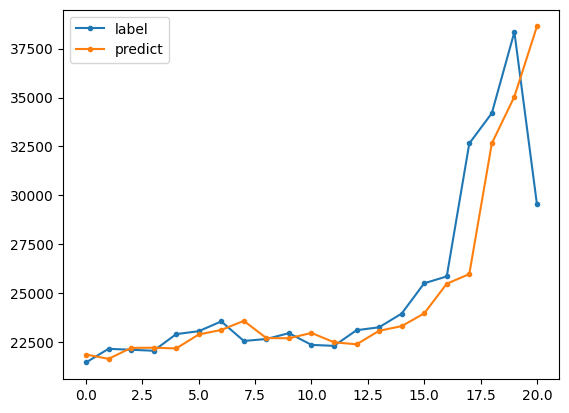

In [13]:
"""
many to one 평가
"""
# 하이퍼 파라미터
input_size = 1
hidden_size = 4
layers = 1
output_size = 1
learning_rate = 0.01
epoch = 300

df = pd.read_csv('./data/20230615_현대바이오.csv')
# x_train, y_train = split_train(np.ravel(df['시가'].values), 4)
# print(df['시가'][:10])
# print(x_train[:10])
# print(y_train[:10])
mms = MinMaxScaler()
normal = mms.fit_transform(df[['시가']])
print(normal.shape)
# train, test 데이터 나누기
normal90, normal10 = np.split(normal, [int(len(normal)*0.9)])
x_train, y_train = split_train(np.ravel(normal90), hidden_size)
print(x_train.shape)
print(y_train.shape)
x_test, y_test = split_train(np.ravel(normal10), hidden_size)

model = LSTMModel(input_size, hidden_size, layers, output_size, normal)

cost = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_value=[]
for i in range(epoch + 1):
    prediction = model(x_train)
    output = cost(prediction, y_train)
    loss_value.append(output)

    optimizer.zero_grad()
    output.backward()
    optimizer.step()

print(loss_value[-10:])
predict_test = model(x_test)
predict_test = mms.inverse_transform(predict_test.tolist())
y_test = mms.inverse_transform(y_test.tolist())
# 시점을 맞춰서 보기 
# predict_test = np.delete(predict_test, 0)
# y_test = np.delete(y_test, -1)
# print(y_test)
# print(predict_test)

plt.plot(np.ravel(y_test), ".-", label='label')
plt.plot(np.ravel(predict_test), ".-", label="predict")
plt.legend()

[tensor(0.0682, grad_fn=<MseLossBackward0>), tensor(0.0459, grad_fn=<MseLossBackward0>), tensor(0.0346, grad_fn=<MseLossBackward0>), tensor(0.0356, grad_fn=<MseLossBackward0>)]


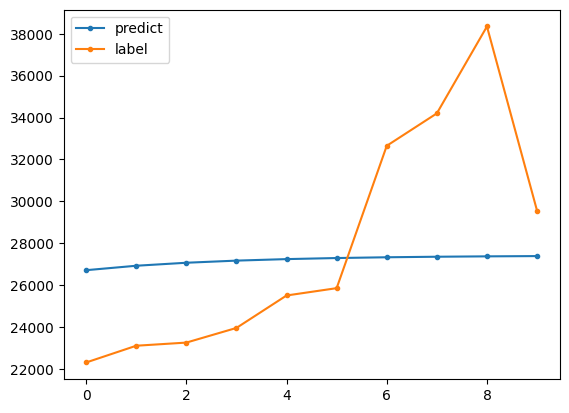

In [16]:
"""
예측값 보기
"""
input_size = 1
hidden_size = 30
layers = 1
output_size = 1
learning_rate = 0.01
epoch = 3

df = pd.read_csv('./data/현대바이오 copy.csv')
mms = MinMaxScaler()
normal = mms.fit_transform(df[['시가']])
x_train, y_train = split_train(np.ravel(normal), hidden_size)

model = LSTMModel(input_size, hidden_size, layers, output_size, normal)
cost = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_value=[]
for i in range(epoch + 1):
    prediction = model(x_train)
    output = cost(prediction, y_train)
    loss_value.append(output)

    optimizer.zero_grad()
    output.backward()
    optimizer.step()
print(loss_value[-10:])

# 추론
predict_count = 10
result = model.predict(predict_count)

result = mms.inverse_transform(result.tolist())
plt.plot(result, '.-', label='predict')
df2 = pd.read_csv('./data/20230615_현대바이오.csv')
plt.plot(df2['시가'][-predict_count:].values, '.-', label='label')
plt.legend()

In [61]:
import datetime

date = df.iloc[-1, 0]
last_date = datetime.datetime.strptime(date, "%Y-%m-%d")

period = []
for i in range(1, predict_count+1):
    day = last_date + datetime.timedelta(days=i)
    period.append(day.strftime("%Y-%m-%d"))
print(period)

pd.DataFrame({df.columns[0]: period, df.columns[1]: np.ravel(result)}).to_csv('./결과.csv', index=False)

['2023-06-13', '2023-06-14', '2023-06-15', '2023-06-16', '2023-06-17']
